# Detect News Topics

In [1]:
# To install packages that are not installed by default, uncomment the last two lines of this cell 
# and replace <package list> with a list of needed packages.
# This will ensure the notebook has all the dependencies and works everywhere

#import sys
#!{sys.executable} -m pip install <package list>

In [ ]:
import sys
!{sys.executable} -m pip install wget nltk tensorflow==2.7.1

In [1]:
#Libraries
import pandas as pd
import numpy as np
import wget
import os
from shutil import unpack_archive

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

pd.set_option("display.max_columns", 101)
pd.set_option('display.max_colwidth', 100)
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amojdeh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Run this cell block to download and extract dataset
!wget 'https://hr-projects-assets-prod.s3.amazonaws.com/foi382a7hf4/0dc59d22288ac5a7d47a2ebb00892009/test.csv'
!wget 'https://hr-projects-assets-prod.s3.amazonaws.com/foi382a7hf4/c023cef807b653f08f687cebe85c92e6/train.csv'

In [5]:
# # download and extract GloVe embeddings
!wget https://hr-projects-assets-prod.s3.amazonaws.com/foi382a7hf4/588c1005784efcdb25c9ecf88b082e8e/glove.6B.50d.zip
# !unzip -q glove.6B.50d.zip

## Data Description

Column | Description
:---|:---
`title` | Title of the news article
`description` | Description of the news article
`category` | Topic of the news article. (`0 - World`, `1 - Sports`, `2 - Business`, `3 - Sci/Tech`)

In [7]:
# The training dataset containing the news articles and corresponding categories is already loaded below.
data = pd.read_csv("train.csv")
data.head()

,title,description,category
0,Soft Drink Company Takes The Cooking Out Of Thanksgiving,"If you want the taste of Thanksgiving without the cooking and without the calories, a Seattle so...",2
1,Izenberg: Trinidad refuses to take shortcuts in comeback,"He was tired. He had finally lost a fight after 40 straight victories. Since the age of 7, Felix...",1
2,Bush gives hell to UN,NEW YORK -- US President George W. Bush yesterday scolded the United Nations for failing to join...,0
3,"EU, meeting Iraqi PM, urged to heal divisions",BRUSSELS : European leaders were urged to forget their past divisions over Iraq as they met the ...,0
4,on the record:,"JACOBABAD: I was under no pressure to sign the presidents dual office bill, said Mohammadmian So...",0


## Deep Learning

Build a neural network that can predict the category of the news article.
- **The model's performance will be evaluated on the basis of accuracy score.**

### Prepare Data

*   We first shuffle the dataset to remove any positional bias.
*   We then split the data into training and validation sets with 80:20 split ratio.
*   We then combine the description and title into one column called 'content' in order to capture information from both of them while training.
*   We then remove the stopwords from the articles for both training and validation sets and split them into articles and category dataframes.

In [8]:
# shuffle data and create training and validation sets
data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)
data_train, data_validation = train_test_split(data_shuffled, test_size=0.15, random_state=42)

In [9]:
# create the content column
data_train.loc[:, 'content'] = data_train.loc[:, 'description'] + ' ' + data_train.loc[:, 'title']
data_validation.loc[:, 'content'] = data_validation.loc[:, 'description'] + ' ' + data_validation.loc[:, 'title']

In [10]:
# helper function to remove stopwords
def remove_stopwords(x):
    for word in STOPWORDS:
        token = ' ' + word + ' '
        x = x.replace(token, ' ')
        x = x.replace(' ', ' ')
    return x

In [11]:
# remove stopwords and split into articles and category dataframes
train_articles = data_train.loc[:, 'content'].apply(remove_stopwords)
train_category = data_train.loc[:, 'category']
val_articles = data_validation.loc[:, 'content'].apply(remove_stopwords)
val_category = data_validation.loc[:, 'category']

Now, we split the training posts into tokens and build a vocabulary of the top 65000 words.

For the purposes of tokenization, we just use the basic Keras Tokenizer which removes any punctuations in the text and splits by the `' '` delimiter.

For all the words not in the vocabulary, we assign a special `<OOV>` token.

We also print the top-10 words in our vocabulary.

In [12]:
# tokenize and build vocab
VOCAB_SIZE = 65000
OOV_TOKEN = '<OOV>'
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

print(dict(list(word_index.items())[0:10]))

{'<OOV>': 1, '39': 2, 's': 3, 'the': 4, 'new': 5, 'said': 6, 'reuters': 7, 'ap': 8, 'a': 9, 'gt': 10}


We now load pre-trained GloVe embeddings which we can use as out-of-box word representations to train our model.

For that, we do the following:
*    We first download the GloVe embeddings.
*    We then create an embedding index where we store each word in the embeddings file and its corresponding embedding.
*    Using the embeddings index and the reverse_word_index of our vocabulary, we create the embedding matrix.

In [13]:
# create the embedding index
EMBEDDING_DIM = 50
path_to_glove_file = f'glove.6B.{EMBEDDING_DIM}d.txt'

embeddings_index = {}
with open(path_to_glove_file, encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [14]:
# create the embedding matrix
hits = 0
misses = 0

embedding_matrix = np.zeros((VOCAB_SIZE + 1, EMBEDDING_DIM))

for i in range(VOCAB_SIZE + 1):
    word = reverse_word_index.get(i, None)
    if word is None:
        misses += 1
        continue
    embedding_vector = embeddings_index.get(word, None)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 53501 words (11500 misses)


We now convert our training and validation articles into sequences using the built vocabulary so that they can be used to train the model. We also convert the labels into numpy arrays.

We also pad/truncate the sequences shorter/longer than 40 words.

In [15]:
# build sequences and pad/truncate
MAX_LENGTH = 40
TRUNC_TYPE = 'post'
PADDING_TYPE = 'post'

train_sequences = tokenizer.texts_to_sequences(train_articles)
train_padded = pad_sequences(train_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNC_TYPE)

val_sequences = tokenizer.texts_to_sequences(val_articles)
val_padded = pad_sequences(val_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNC_TYPE)

In [16]:
# convert labels
train_label = np.array(train_category).reshape(-1, 1)
val_label = np.array(val_category).reshape(-1, 1)

We do a little sanity check to see that if all the preprocessing steps are done correctly.

In [17]:
# sanilty check
def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '<pad>') for i in text])

print(decode_article(train_padded[10]))
print('---')
print(train_articles.iloc[10])

a computer hacker accessed names social security numbers 1 4 million californians breaking university california berkeley computer system hacker hits california university computer <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
---
A computer hacker accessed names Social Security numbers 1.4 million Californians breaking University California, Berkeley, computer system. Hacker Hits California University Computer


### Prepare and Train Model
> #### Task:
- **Use the processed data to build train a deep learning model using tensorflow.**

#### Building a sequential model using TensorFlow Keras
Due to time constraints, I had to reduce the number of epochs to 4. 

In [77]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=train_padded.shape[1]))

model.add(tf.keras.layers.Conv1D(48, 5, activation='relu', padding='valid'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(5, activation='softmax'))
model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 4
batch_size = 32

history = model.fit(train_padded, train_label, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    validation_data=(val_padded, val_label))

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 40, 50)            3250000   
                                                                 
 conv1d_13 (Conv1D)          (None, 36, 48)            12048     
                                                                 
 global_max_pooling1d_10 (Gl  (None, 48)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_22 (Dropout)        (None, 48)                0         
                                                                 
 flatten_10 (Flatten)        (None, 48)                0         
                                                                 
 dropout_23 (Dropout)        (None, 48)                0         
                                                     

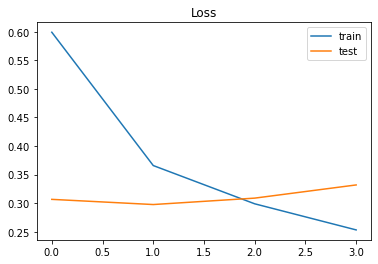

In [78]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

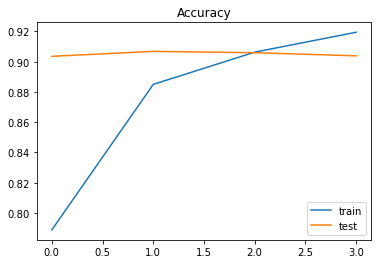

In [79]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

> #### Task:
- **Submit the predictions on the test dataset using your optimized model** <br/>
    For each record in the test set (test.csv), predict the value of the 'category' variable. Submit a CSV file with a header row and one row per test entry.

The file (`submissions.csv`) should have exactly 3 columns:

Column | Description
:---|:---
`title` | Title of the news article
`description` | Description of the news article
`category` | Topic of the news article. (`0 - World`, `1 - Sports`, `2 - Business`, `3 - Sci/Tech`)

In [69]:
test = pd.read_csv("test.csv")
test.head()

,title,description
0,The Playlist: What's Wrong With Digital Music Stores? (PC World),"PC World - Though digital music has come a long way, today's online music stores still have sign..."
1,"Philippine Rail Cars Crash Into Ravine, 100 Trapped",MANILA (Reuters) - Rescuers in the Philippines smashed train windows with axes and hammers Fri...
2,Jets hit rebel city in payback for hotel raid,"BAGHDAD: US fighter jets bombed the rebel-held city of Fallujah yesterday, killing at least 10 p..."
3,Intel Helps Asian PC Partners Ship With Linux (TechWeb),TechWeb - Chipmaker provides Linux tools to reach growing market there.
4,4 French schoolgirls expelled for wearing head scarves,Two Muslim girls were expelled Wednesday from high school for refusing to remove their head scar...


### Prepare Data
Similar to the train data, we prepare the test data.

In [70]:
# combine description and title
test.loc[:, 'content'] = test.loc[:, 'description'] + ' ' + test.loc[:, 'title']

In [71]:
# remove stopwords
test_articles = test.loc[:, 'content'].apply(remove_stopwords)

In [72]:
# build sequences and pad/truncate
test_sequences = tokenizer.texts_to_sequences(test_articles)
test_padded = pad_sequences(test_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNC_TYPE)

### Generate Predictions
> #### Task:
- **Write the code to generate predictions on the test data.**

In [84]:
pred = model.predict(test_padded)
prediction = []
for i in pred:
    prediction.append(np.argmax(i))

In [87]:
test.drop(['content'], inplace=True, axis=1)

In [90]:
test.head()

,title,description,category
0,The Playlist: What's Wrong With Digital Music Stores? (PC World),"PC World - Though digital music has come a long way, today's online music stores still have sign...",3
1,"Philippine Rail Cars Crash Into Ravine, 100 Trapped",MANILA (Reuters) - Rescuers in the Philippines smashed train windows with axes and hammers Fri...,0
2,Jets hit rebel city in payback for hotel raid,"BAGHDAD: US fighter jets bombed the rebel-held city of Fallujah yesterday, killing at least 10 p...",0
3,Intel Helps Asian PC Partners Ship With Linux (TechWeb),TechWeb - Chipmaker provides Linux tools to reach growing market there.,3
4,4 French schoolgirls expelled for wearing head scarves,Two Muslim girls were expelled Wednesday from high school for refusing to remove their head scar...,0


In [91]:
#Submission
test.to_csv('submissions.csv', index=False)